<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="cognitiveclass.ai logo">
</center>


# Non-Negative Matrix Factorization

Estimated time needed: **45** minutes





You've been hired by a video streaming platform that specializes in kids content. The company would like to ensure that all content on the platform does not infringe on a copyright written material. The company has created an image database of copyrighted material, not only must you detect the same images you must detect similar images. Your  job is to come up with an image retrieval system to find the most similar image to each image in the provided dataset. Because your model is used for legal purposes it must be interpretable, this means it should be able to determine why the images are similar. As a result, you will use Non-Negative Matrix factorization since the factorized matrices can be interpreted as real images. You will use the [Anime Face Dataset](https://www.kaggle.com/datasets/splcher/animefacedataset?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork821-2023-01-01) from kaggle.



<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/images/fake_cartoon.png" alt="cognitiveclass.ai logo">

<a href="https://www.piratesandprincesses.net/the-story-of-goodtimes-and-their-numerous-disney-knockoffs/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork821-2023-01-01"> image source</a>


## Table of Contents

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li><a href="#Datasets">Datasets</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
        </ol>
    </li>
    <li>
        <a href="#Background">Background</a>
        <ol>
               <li><a href="#What's a Non-Negative Matrix Fatorization?">What's a Non-Negative Matrix Fatorization?</a></li>
        </ol>
    </li>
  <li><a href="#Applying Non-Negative Matrix Factorization">Applying Non-Negative Matrix Factorization</a></li>
  <li><a href="#Image Retrieval System">Image Retrieval System</a></li>
   <li><a href="#Exercises">Exercises</a>
       <ol>
            <li><a href="#Exercise 1">Exercise 1</a></li>
            <li><a href="#Exercise 2">Exercise 2</a></li>
            <li><a href="#Exercise 3">Exercise 3</a></li>
            <li><a href="#Exercise 4">Exercise 4</a></li>
            <li><a href="#Exercise 5">Exercise 5</a></li>
        </ol>
    </li> 
 </ol>    
     
    
     

## Objectives

After completing this lab you will be able to:

- __Understand__ Basics Matrix operations  such as Matrix addition  , Vector Multiplication，and Eigen decomposition

- __Apply__ Apply these Matrix operations using numpy


## Datasets

Download and unzip the **images** dataset: 


In [2]:
import skillsnetwork

await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/images/images.tar.gz", overwrite=True)

  0%|          | 0/20006 [00:00<?, ?it/s]

Saved to '.'


In [3]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
from numpy.random import RandomState
from sklearn.decomposition import NMF
from os import listdir, getcwd
from os.path import isfile, join
from PIL import Image, ImageOps

In [5]:
import warnings
warnings.simplefilter('ignore')

### Defining Helper Functions


Load train and test set:


In [6]:
def get_data_matrix(test=False, Length=100, Width=100, mypath="images/"):

    files = [join(mypath,f) for f in listdir(mypath) if isfile(join(mypath, f)) and f[0] != '.']
    if mypath + '/.DS_Store' in files:
        files.remove(mypath + '/.DS_Store')
  
    if test:
        print("test data")
        files = files[9000: 10000]
        
    else:
        print("training data")
        files = files[0: 9000]
        
    print(len(files))
    X = np.zeros((len(files), Length * Width))

    for i, file in enumerate(files):
        img = Image.open(file).resize((Width, Length))
        img = ImageOps.grayscale(img)
        I = np.array(img)
 
        X[i, :] = I.reshape(1, -1)
    return X

Plot image vectors:


In [7]:
def reshape_row(x):
    plt.imshow(x.reshape(Length, Width), cmap="gray")

This threshold function outputs an index if the input ```similar_distance``` is grater than or less than ```min_``` and ```max_```.


In [8]:
def threshold(similar_distance, max_=0.1, min_=0):
    dataset_index = np.where(np.logical_and(similar_distance > min_, similar_distance < max_))[0]
    query_index = similar_index[np.logical_and(similar_distance > min_, similar_distance < max_)]
    return dataset_index, query_index

Plot dataset images and query images, ```X``` and ```X_q``` are global variables.


In [9]:
def plot_data_query(dataset_index, query_index, N):
    
    for data_sample, query_sample in zip(dataset_index[0: N], query_index[0: N]):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        reshape_row(X[data_sample])
        plt.title("dataset sample {}".format(data_sample))
        plt.subplot(1, 2, 2)
        reshape_row(X_q[query_sample])
        plt.title("query sample match {}".format(query_sample))
        plt.show()
        print("-----------------------------------------------------")

## Background


### What's a Non-Negative Matrix Factorization?


In Non-Negative Matrix Factorization (NNMF) sometimes called non-negative matrix approximation, a $N x D$ matrix $\mathbf{X}$, where $N$ is the number of samples and $D$ is the dimension of features, contains all non-negative values. In NNMF we construct a non-negative  approximation of $\mathbf{X}$, $\mathbf{\hat{X}}$ such that $\mathbf{\hat{X}}$ is a product of two non-negative matrices $\mathbf{W}$ and $\mathbf{H}$, i.e:

$$\mathbf{\hat{X}}=\mathbf{WH}$$

where the $r$ rows of $\mathbf{H}$ are called the basis, and we are going to represent the matrix $\mathbf{X}$ in terms of this basis. 

Each row of $\mathbf{W}$, ${w}_i$ is called an encoding of the corresponding ${x}_i$ in $\mathbf{X}$, which represents "how much" of each basis in $\mathbf{H}$ is to represent ${x}_i$. ${\hat{x}_i}$ is thus a linear combination of the rows of $\mathbf{H}$.


## Applying Non-Negative Matrix Factorization


**Image retrieval** is used for searching and retrieving images from a large database of digital images. Here we would like to find identical or similar  animated faces  for copyright reasons.


Consider the matrix $\mathbf{X}$ where each row is a flattened $100\times 100$ image.


In [10]:
Length, Width = 100, 100
X = get_data_matrix(test=False, Length=100, Width=100, mypath='images')
X.shape

training data
9000


(9000, 10000)

We can apply ```sklearn.decomposition.NMF``` to obtain the  non-negative matrices, i.e. matrices with all non-negative elements, $(\mathbf{W}$, $\mathbf{H})$ whose product approximates the non-negative matrix $\mathbf{X}$. 

Consider the following parameters when building a simple NMF object: 

```n_components```: int; Number of components, if n_components is not set all features are kept.

```tolfloat```: default=1e-4; Tolerance of the stopping condition.

```max_iter```: int, (default=200); Maximum number of iterations before timing out.


In [11]:
n_components = 10

In [12]:
nmf_estimator = NMF(n_components=n_components, tol=5e-3, max_iter=2000)
nmf_estimator.fit(X)

NMF(max_iter=2000, n_components=10, tol=0.005)

The **.components_** method returns the basis found:


In [13]:
H = nmf_estimator.components_
H.shape

(10, 10000)

We can reshape the obtained 10 basis into images, and they appear like faces in the dataset:


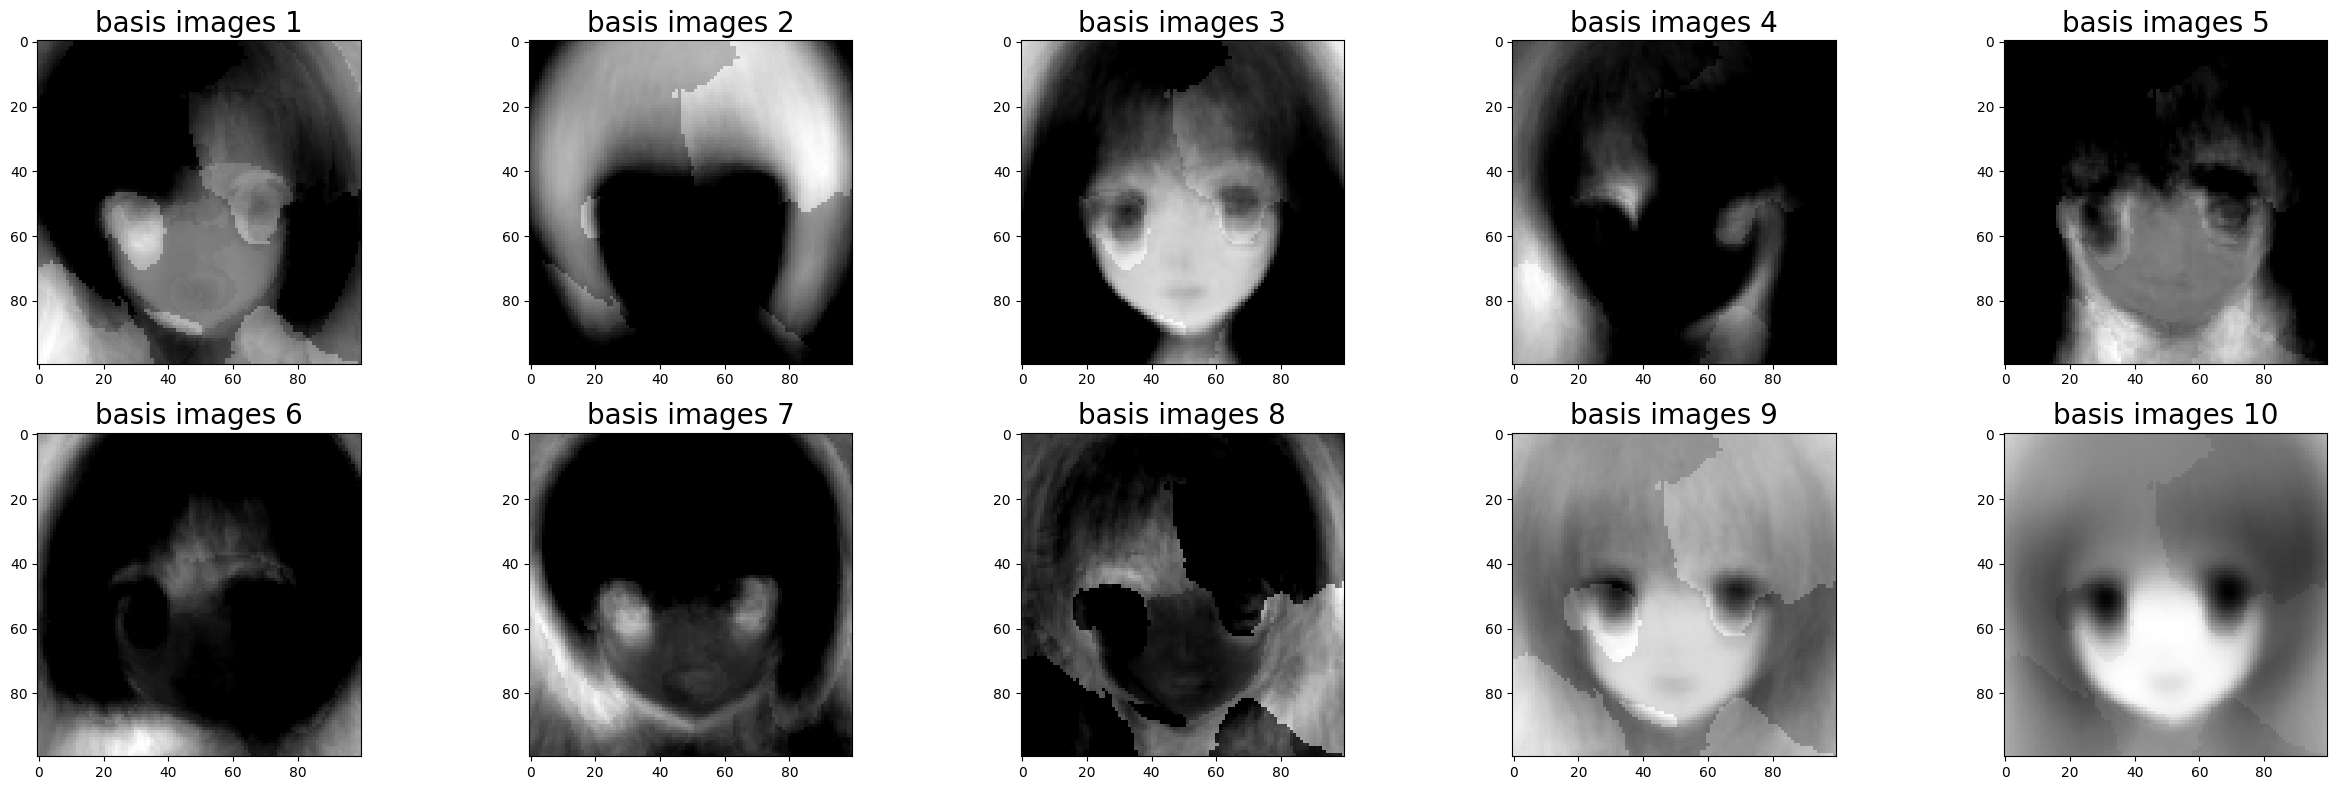

In [14]:
plt.figure(figsize=(25, 8))

for i, h in enumerate(H):
    plt.subplot(2, 5, i + 1)
    reshape_row(h)
    plt.title(f"basis images {i + 1}", fontsize=20)

plt.tight_layout()

We can obtain the encodings of all the images using the **transform** method of the fitted **nmf_estimator**:


In [15]:
W = nmf_estimator.transform(X)

For each of the 9000 images we have an encoding of dimension 10:


In [16]:
W.shape

(9000, 10)

The encoding tells you the projection of each image in $\mathbf{X}$ on a particular basis. Here we plot out the encoding magnitude for the $i$th image on each basis.


Text(0.5, 1.0, 'encodings for image 2')

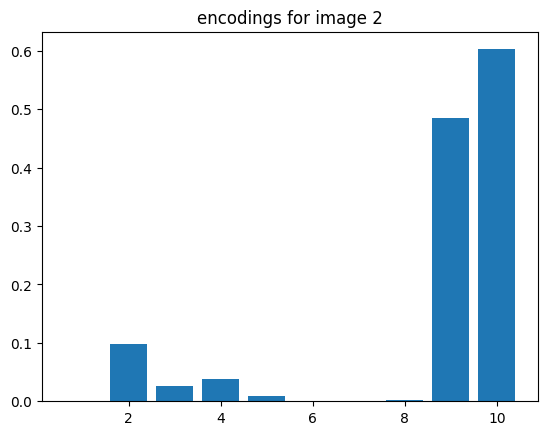

In [17]:
i = 1
w = W[i, :]
plt.bar([n + 1 for n in range(len(w))], w)
plt.title(f"encodings for image {i + 1}")

We see that for image 1, the second encoding has the highest magnitude, thus we can plot out the basis associated with this encoding (i.e, the second basis) and see that it's very similar to the image. The 9th encoding has a small magnitude, we see the associated basis looks nothing like the image:


Text(0.5, 1.0, 'Dissimilar Basis 9')

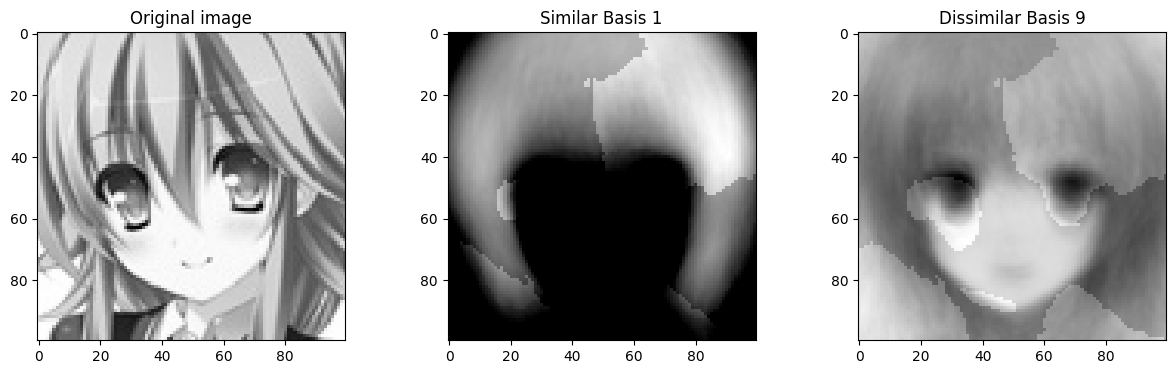

In [18]:
plt.figure(figsize=(15, 4))

plt.subplot(131)
reshape_row(X[i, :])
plt.title("Original image")

plt.subplot(132)
reshape_row(H[1, :])
plt.title("Similar Basis 1")

plt.subplot(133)
reshape_row(H[8, :])
plt.title("Dissimilar Basis 9")

In [19]:
Xhat = nmf_estimator.inverse_transform(W)

Each row of $\mathbf{\hat{X}}$ corresponds to an image. We can reshape the row into an image and plot the approximations:


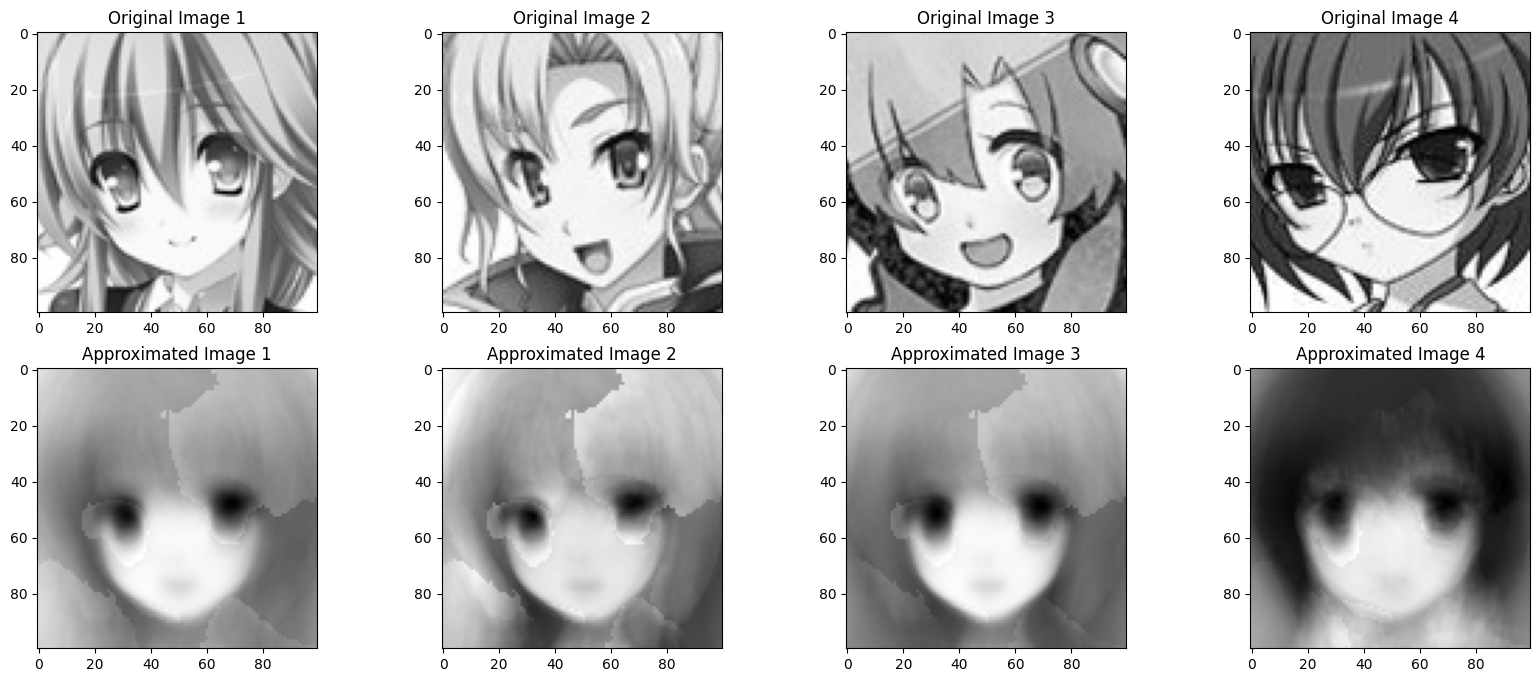

In [20]:
plt.figure(figsize=(20, 8))

for i in range(1, 5):
    plt.subplot(2, 4, i)
    reshape_row(X[i])
    plt.title(f"Original Image {i}")
    
    plt.subplot(2, 4, i + 4)
    reshape_row(Xhat[i])
    plt.title(f"Approximated Image {i}")

We can verify that the scikit-learn's **inverse_transform** method essentially performs the following matrix operation:


In [21]:
Xhat_M = W @ H

We see the results are identical quantitatively (for the first 10 grayscale values of first image):


In [22]:
np.equal(Xhat[0, : 10], Xhat_M[0, :10])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

and qualitatively or visually for the second to fifth image in the dataset: 


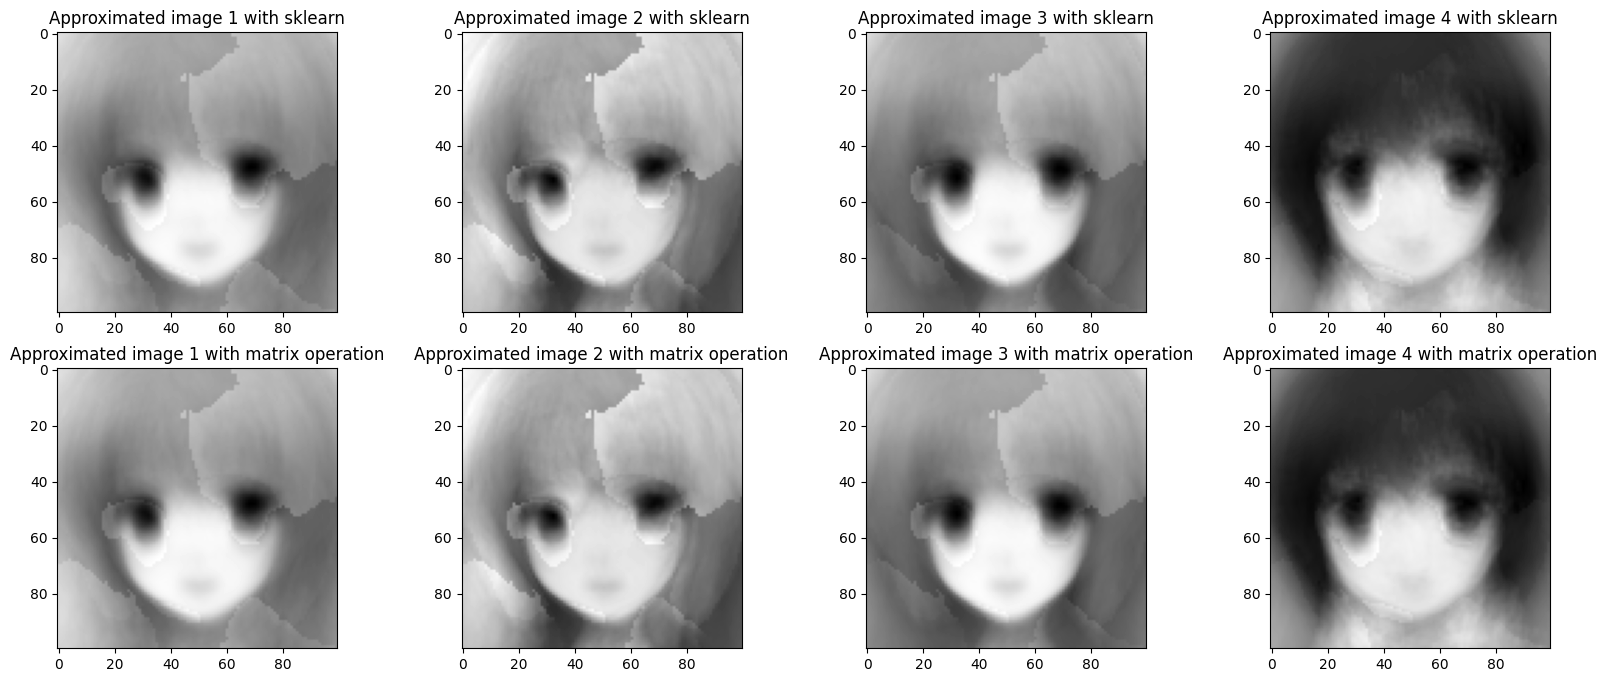

In [23]:
plt.figure(figsize=(20, 8))

for i in range(1, 5):
    plt.subplot(2, 4, i)
    reshape_row(Xhat[i])
    plt.title(f"Approximated image {i} with sklearn")
    
    plt.subplot(2, 4, i + 4)
    reshape_row(Xhat_M[i])
    plt.title(f"Approximated image {i} with matrix operation")

We can reconstruct the image by adding one component multiplied by it's encoding at a time. This is shown in the following lines of code, as each successive component is added we see the image looks more and more like it's approximation:


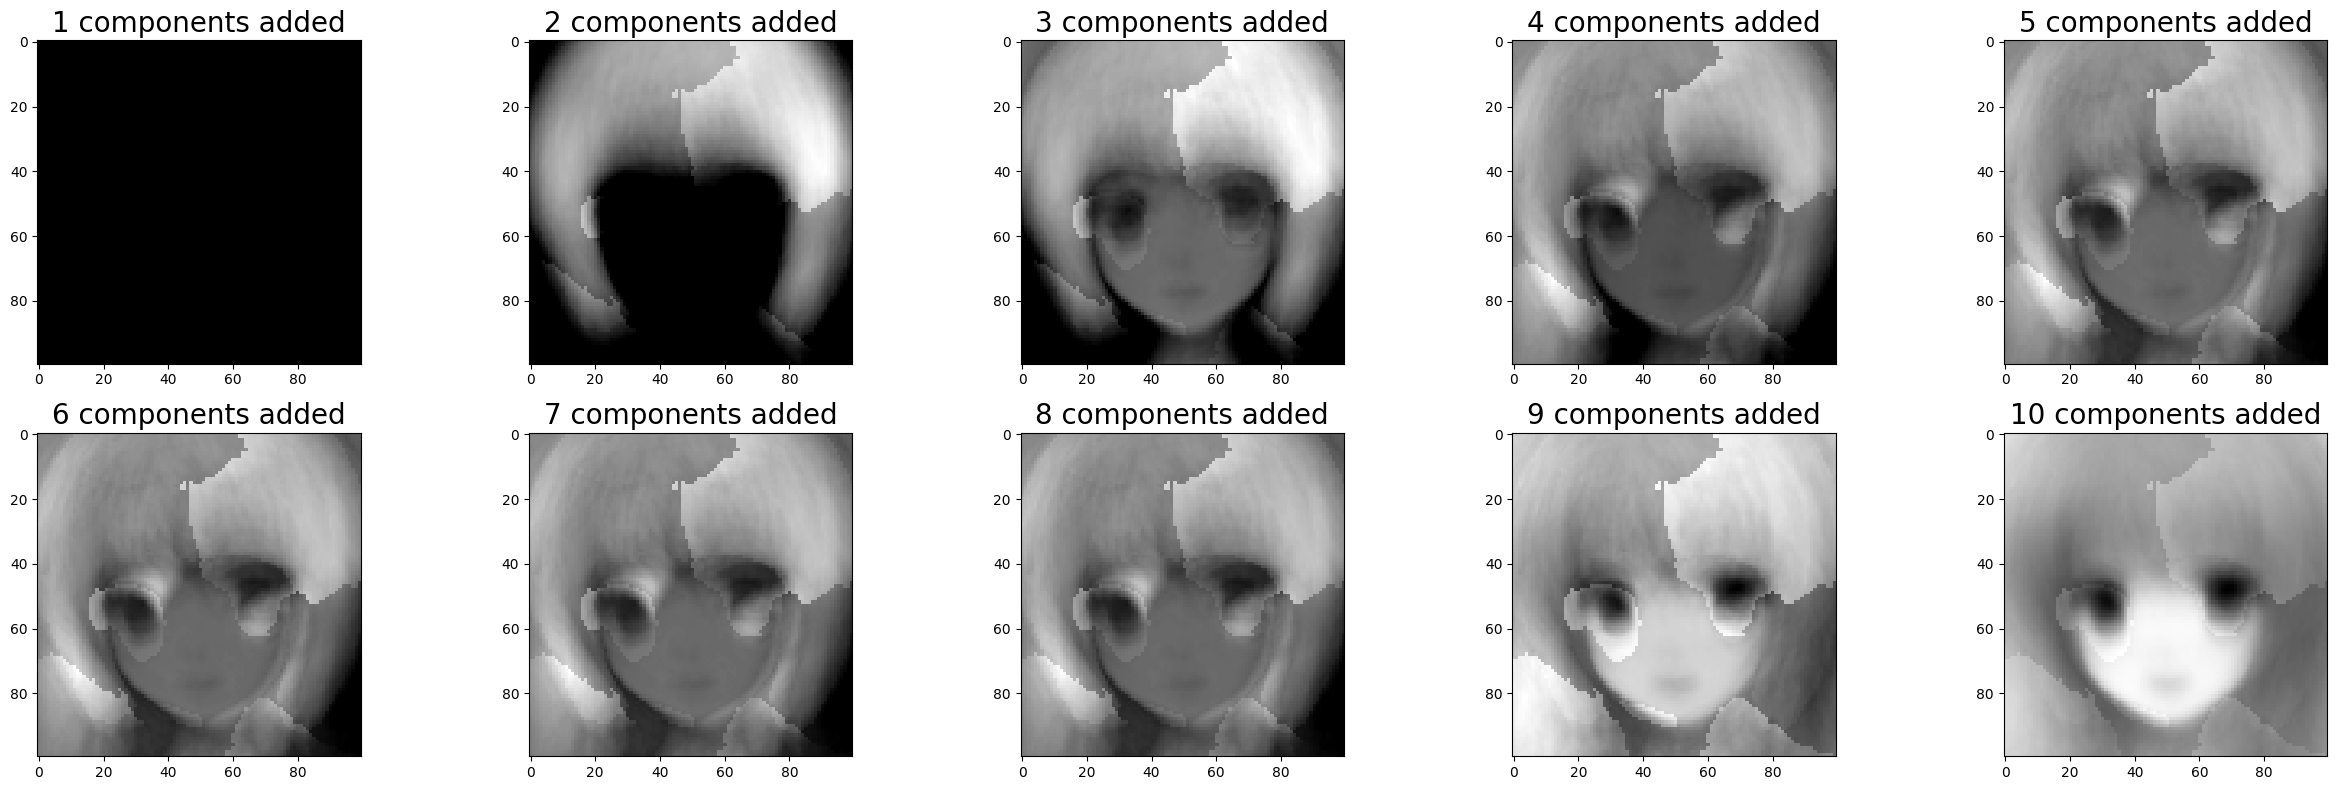

In [24]:
# initialize an image array with 10000 zeros which will be reshaped as 100x100  
image = np.zeros((1, 10000))

plt.figure(figsize=(25, 8))
for i, (w_, h) in enumerate(zip(w, H)):
    
    # w is the encoding vector of the first image in X
    # reconstruction of the image is a linear combination of H 
    plt.subplot(2, 5, i + 1)
    image += w_ * h
    reshape_row(image)
    plt.title(f"{i + 1} components added", fontsize=20)

plt.tight_layout()

## Image Retrieval System 


An image retrieval system is a system used for browsing, searching and retrieving images from a large database of digital images. In this section we will create an image retrieval system to find similar cartoon characters for copyright infringement. 

We define the query dataset as the set of 1000 images. If these images are similar to the images in our original dataset, they may be considered as copyright infringement. We load the query dateset into```X_q``` where each row corresponds to a flattened $100\times 100$ image:


In [25]:
X_q = get_data_matrix(test=True, Length=100, Width=100, mypath="images")
X_q.shape

test data
1000


(1000, 10000)

The code in the next cell helps us retain much of the important information of the query images and reduces factors that make similar images appear differently such as noise, rotation and scale. In addition, the code results in a matrix `W_q` that requires less computation for calculating the distance metrics. As such we will use the code to find the similar images.


In [26]:
W_q = nmf_estimator.transform(X_q)
W_q.shape

(1000, 10)

We define  the  distance matrix as a  matrix ```D``` containing the distances, taken pairwise, between the elements of the query dataset and the original dataset.  We will use the cosine similarity that computes the normalized dot product of vectors. That is, for $x$ and $x'$ their cosine similarity  is defined as:

$$1-\frac{x' x^T}{\|x'\| \|x\|}$$


Consider the following set of codes in which case that we represent as 2D vectors.  The original  dataset is in yellow and the query dataset is in blue. We see that the image $h_2$ is nearest  to  $h_{2q}$, and similarly image $h_3$ is nearest  to  $h_{1q}$.



<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/images/NNMF_vectors.png" width="500" alt="https://pxhere.com/en/photo/1536663">


The resultant distance Matrix is shown below, each row consists of a dataset sample and each column consists of a query dataset sample. Each element of the distance Matrix comprises of the distance between the sample of that particular row and that particular column. We see in this case samples that are close together have the smallest  value. For example, image $h_2$  in the second row is nearest to $h_{2q}$ in the second column.
